In [2]:
%load_ext autoreload
%autoreload 2

In [38]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [96]:
df = pd.read_csv("data/cherry_blossoms.csv", sep=";")
df.head()

,year,doy,temp,temp_upper,temp_lower
0,801,NaN,NaN,NaN,NaN
1,802,NaN,NaN,NaN,NaN
2,803,NaN,NaN,NaN,NaN
3,804,NaN,NaN,NaN,NaN
4,805,NaN,NaN,NaN,NaN


In [97]:
df.describe()

,year,doy,temp,temp_upper,temp_lower
count,1215.000000,827.000000,1124.000000,1124.000000,1124.000000
mean,1408.000000,104.540508,6.141886,7.185151,5.098941
std,350.884596,6.407036,0.663648,0.992921,0.850350
min,801.000000,86.000000,4.670000,5.450000,0.750000
25%,1104.500000,100.000000,5.700000,6.480000,4.610000
50%,1408.000000,105.000000,6.100000,7.040000,5.145000
75%,1711.500000,109.000000,6.530000,7.720000,5.542500
max,2015.000000,124.000000,8.300000,12.100000,7.740000


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1215 entries, 0 to 1214
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   year        1215 non-null   int64  
 1   doy         827 non-null    float64
 2   temp        1124 non-null   float64
 3   temp_upper  1124 non-null   float64
 4   temp_lower  1124 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 47.6 KB


Text(0.5, 1.0, 'temp')

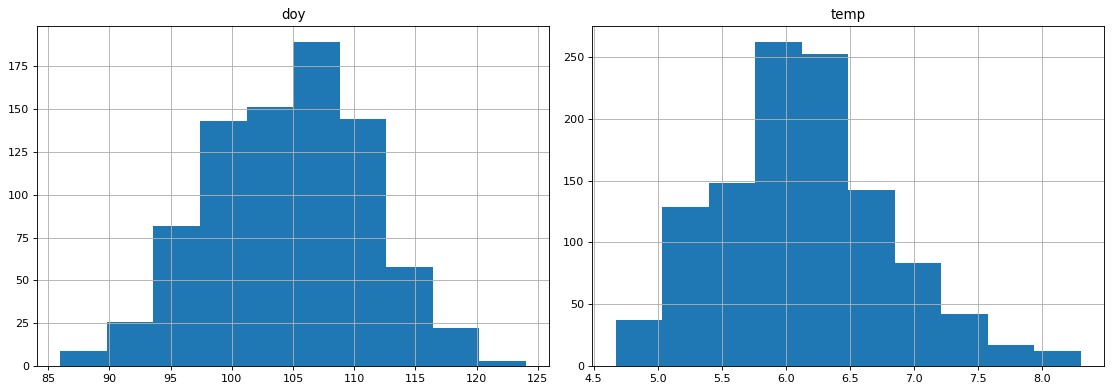

In [99]:
plt.figure(figsize=(14,5), dpi=80)
plt.subplot(1,2,1)
df.doy.hist()
plt.title("doy")

plt.subplot(1,2,2)
df.temp.hist()
plt.tight_layout()
plt.title("temp")

<AxesSubplot:xlabel='temp', ylabel='doy'>

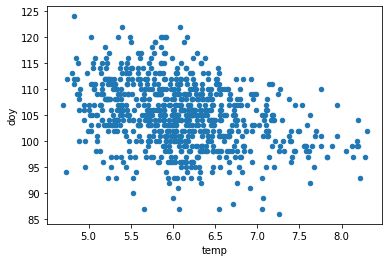

In [100]:
df.plot.scatter("temp", "doy")

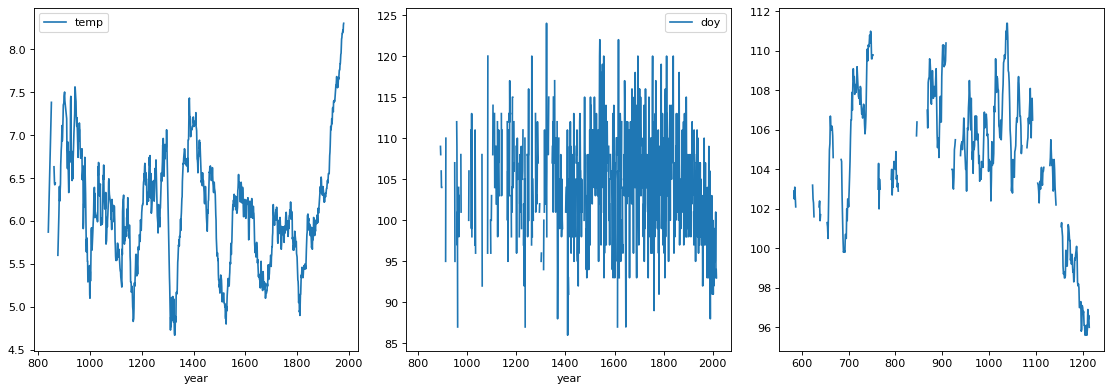

In [101]:
plt.figure(figsize=(14,5), dpi=80)
ax = plt.subplot(1,3,1)
df.plot("year", "temp", ax=ax)

ax = plt.subplot(1,3,2)
df.plot("year", "doy", ax=ax)

ax = plt.subplot(1,3,3)
df.doy.rolling(window=10).mean().plot()
plt.tight_layout()


In [104]:
df['temp_lag_1'] = df.temp.shift(1)
df['temp_lag_2'] = df.temp.shift(2)
df['temp_lag_3'] = df.temp.shift(3)

In [113]:
df['doy_std'] = (df.doy - df.doy.min()) / (df.doy.max() - df.doy.min())
df['year_std'] = (df.year - df.year.min()) / (df.year.max() - df.year.min())
df['temp_std'] = (df.temp - df.temp.mean()) / df.temp.std()
df['temp_std_lag_1'] = (df.temp.shift(1) - df.temp.shift(1).mean()) / df.temp.shift(1).std()
df['temp_std_lag_2'] = (df.temp.shift(2) - df.temp.shift(2).mean()) / df.temp.shift(2).std()
df['temp_std_lag_3'] = (df.temp.shift(3) - df.temp.shift(3).mean()) / df.temp.shift(3).std()
df['industrial_era'] = (df.year >= 1880).astype(int)
df = df.dropna().copy()

In [114]:
with pm.Model() as model:
    sigma = pm.Exponential("sigma", lam=1)
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta1 = pm.Normal("beta1", mu=0, sigma=0.2)
    beta2 = pm.Normal("beta2", mu=0, sigma=0.2)
    beta3 = pm.Normal("beta3", mu=0, sigma=0.2)
    beta4 = pm.Normal("beta4", mu=0, sigma=0.2)
    betaCO2 = pm.Normal("betaCO2", mu=0, sigma=0.2)

    mu = alpha + beta1 * df.temp_std + beta2 * df.temp_std_lag_1 + \
        beta3 * df.temp_std_lag_2 + beta4 * df.temp_std_lag_3 + betaCO2 * df.industrial_era
    
    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=df.doy_std)

    samples = pm.sample(2000)
    prior = pm.sample_prior_predictive()
    posterior = pm.sample_posterior_predictive(samples)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta1, beta2, beta3, beta4, betaCO2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 18 seconds.


In [147]:
with pm.Model() as model2:
    sigma = pm.Exponential("sigma", lam=1)
    alpha = pm.Normal("alpha", mu=0, sigma=0.2)
    beta1 = pm.Normal("beta1", mu=0, sigma=10)
    beta2 = pm.Normal("beta2", mu=0, sigma=10)

    mu = alpha + beta1 * df.temp_std + beta2 * df.temp_std**2
    
    doy = pm.Normal("doy", mu=mu, sigma=sigma, observed=df.doy_std)

    samples2 = pm.sample(2000)
    prior2 = pm.sample_prior_predictive()
    posterior2 = pm.sample_posterior_predictive(samples2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, beta1, beta2]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


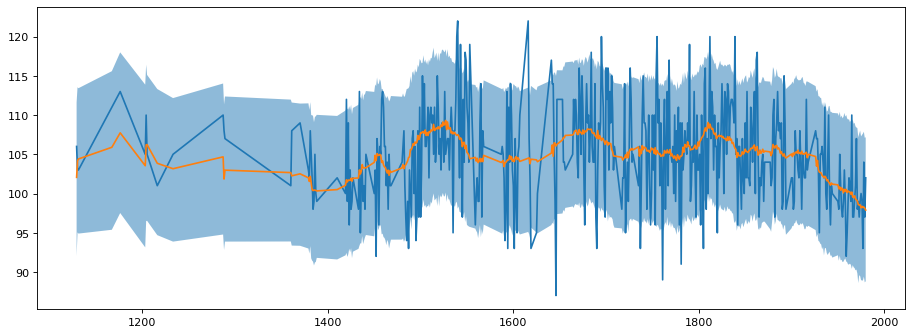

In [146]:
plt.figure(figsize=(14,5), dpi=80)
doy_pos = posterior.posterior_predictive["doy"][0].mean(axis=0)
plt.plot(df.year, df.doy)
plt.plot(df.year, doy_pos * (df.doy.max() - df.doy.min()) + df.doy.min())

hdi = az.stats.hdi(posterior.posterior_predictive["doy"], hdi_prob=0.89).to_array().values
hdi = hdi * (df.doy.max() - df.doy.min()) + df.doy.min()

plt.fill_between(df.year, hdi[0][:, 0], hdi[0][:, 1], alpha=0.5)

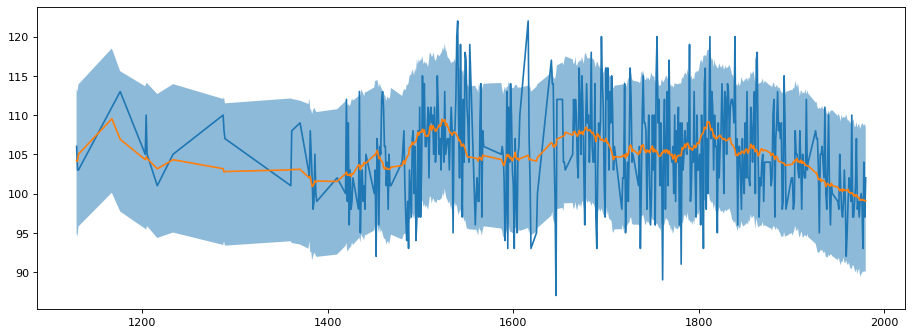

In [148]:
plt.figure(figsize=(14,5), dpi=80)
doy_pos = posterior2.posterior_predictive["doy"][0].mean(axis=0)
plt.plot(df.year, df.doy)
plt.plot(df.year, doy_pos * (df.doy.max() - df.doy.min()) + df.doy.min())

hdi = az.stats.hdi(posterior2.posterior_predictive["doy"], hdi_prob=0.89).to_array().values
hdi = hdi * (df.doy.max() - df.doy.min()) + df.doy.min()

plt.fill_between(df.year, hdi[0][:, 0], hdi[0][:, 1], alpha=0.5)

In [152]:
az.summary(samples)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.509,0.009,0.492,0.526,0.000,0.000,5459.0,5371.0,1.0
beta1,-0.015,0.045,-0.096,0.072,0.001,0.000,4782.0,4720.0,1.0
beta2,-0.057,0.061,-0.173,0.058,0.001,0.001,4421.0,4813.0,1.0
beta3,0.050,0.060,-0.064,0.159,0.001,0.001,4557.0,5272.0,1.0
beta4,-0.053,0.042,-0.133,0.026,0.001,0.000,5204.0,5476.0,1.0
betaCO2,0.039,0.026,-0.010,0.088,0.000,0.000,4801.0,5231.0,1.0
sigma,0.164,0.005,0.153,0.174,0.000,0.000,6827.0,5498.0,1.0


In [153]:
az.summary(samples2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.511,0.009,0.494,0.529,0.0,0.0,4766.0,6016.0,1.0
beta1,-0.070,0.009,-0.087,-0.052,0.0,0.0,5206.0,5980.0,1.0
beta2,0.005,0.006,-0.006,0.015,0.0,0.0,4222.0,5518.0,1.0
sigma,0.164,0.005,0.154,0.174,0.0,0.0,6463.0,5516.0,1.0


In [156]:
az.compare({"m1": samples, "m2": samples2}, ic="waic")

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m2,0,180.539344,3.341089,0.000000,0.590053,16.061818,0.000000,False,log
m1,1,180.123575,5.878106,0.415769,0.409947,16.021929,2.068719,False,log
